In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import caffe
import itertools
import pandas
import cv2

from copy import copy
from collections import OrderedDict
from operator import itemgetter, attrgetter
from matplotlib import pyplot
from scipy import ndimage as ndimage

from caffe import layers as L
from caffe import params as P
import tools

from ntb.db import *

%matplotlib inline
pyplot.rcParams['figure.figsize'] = (10, 6)

# set seed to make randomization reproducible
random.seed(0)
np.random.seed(0)

In [2]:
SUB_DIR = "ft_noaug"

In [4]:
db = NTBDB()

# Data preparation

In [3]:
label_to_ntb = {
    'football': ['footbal', 'football-pitches', 'fotballs'],
    'person': ['full-length-portrait', 'portrait', 'persons'],
    'skiing': [
        'skiing', 'alpine-skiing', 'nordic-skiing', 'biathlon', 'freeskiing', 'freestyle-skiing', 'slalom', 'snowboarding', 'giant-slalom',
        'super-g', 'telemark-skiiing', 'downhill-skiing', 'nordic-combined', 'cross-country-skiing', 'ski-jumping', 'ski-orienteering',
        'long-distance-ski-races', 'ski-flying', 'relay-races', 'skis-and-ski-poles', 'ski-trips',
    ],
    'team-handball': ['team-handball'],
    'woman': ['women'],
    'child': ['children', 'girls', 'boys'],
    'skating': ['icehockey', 'skating', 'figure-skating'],
    'flag': ['flags'],
    'crowd': ['demonstrations', 'supporters', 'crowds'],
    'car': ['cars', 'ambulances', 'electric-cars', 'hybrid-cars', 'limousines', 'sports-cars', 'classic-cars', 'police-cars', 'automobile-racing', 'traffic'],
    'bicycling': ['bicycle-racing', 'bicycling', 'road-bicycle-racing', 'bicycles', 'cross-country-bicycling'],
    'flower': ['flowers', 'bouquet-of-flowers'],
    'man': ['men'],
    'medal': ['medals'],
    'snow': ['snow'],
    'hand': ['hands'],
    'triumph': ['sign-of-triumph'],
    'army': ['soldiers', 'the-armed-forces'],
    'boat': ['boats', 'yachting', 'ferries', 'sailboats', 'passenger-ships', 'cruise-ships', 'fishing-boats'],
    'norwegian-national-costumes': ['norwegian-national-costumes'],
    'landscape': ['landscape'],
    'signs': ['signs', 'traffic-signs'],
    'running': ['running-[athletics]', 'middle-distance-running', 'long-distance-running'],
    'aeroplane': ['aeroplanes'],
    'sky': ['sky', 'clouds'],
    'firemen': ['firemen'],
    'beach-volleyball': ['beach-volleyball'],
    'train': ['trains'],
    'umbrella': ['umbrellas'],
    'swimming': ['swimming-[sports]', 'swimming'],
    'dog': ['dogs'],
    'bus': ['buses'],
    'harbour': ['harbours'],
    'park': ['parks', 'forests'],
    'bridge': ['bridges'],
    'tree': ['trees'],
    'shoe': ['shoes'],
    'beach': ['beaches'],
    'helicopter': ['helicopters', 'rescue-helicopters'],
    'red-carpet': ['red-carpet'],
    'horse': ['horses'],
}
labels = np.asarray(sorted(label_to_ntb.keys()))
assert len(list(itertools.chain.from_iterable(label_to_ntb.values()))) == len(set(itertools.chain.from_iterable(label_to_ntb.values()))), "Dublicates"

In [12]:
ntb_to_label = {ntb_label: label for label, ntb_labels in label_to_ntb.items() for ntb_label in ntb_labels}

metadata = {
    label: np.unique(np.asarray(list(itertools.chain.from_iterable(
        map(itemgetter('filename'), db.by_tag[ntb_label]) for ntb_label in ntb_labels
    )))) for label, ntb_labels in label_to_ntb.items()
}

### Labels distribution

In [67]:
def plot_distribution(data):
    pic_num_distribution = {
        label: imgs.size for label, imgs in data.items()
    }
    data = sorted(pic_num_distribution.items(), key=itemgetter(1), reverse=True)
    df = pandas.DataFrame.from_dict(OrderedDict(data), orient='index')
    df.plot(kind='bar', legend=False)

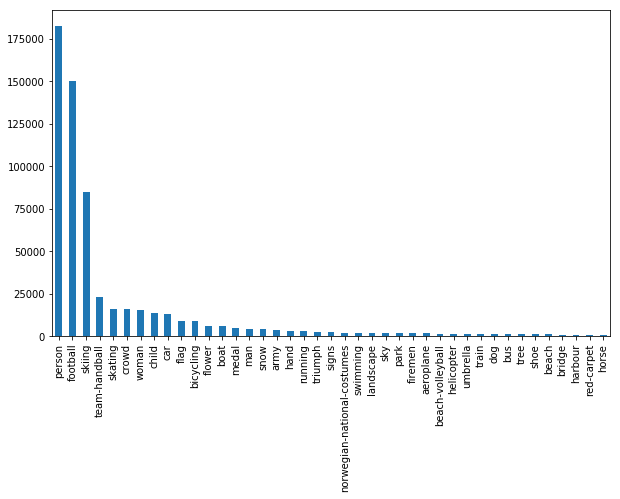

In [68]:
plot_distribution(metadata)

### Reducing imblalance

In [13]:
LIMIT = 10000
metadata_balanced = {label: np.asarray(imgs) for label, imgs in metadata.iteritems()}
for label, imgs in metadata_balanced.iteritems():
    if imgs.size > LIMIT:
        metadata_balanced[label] = np.random.choice(imgs, LIMIT)

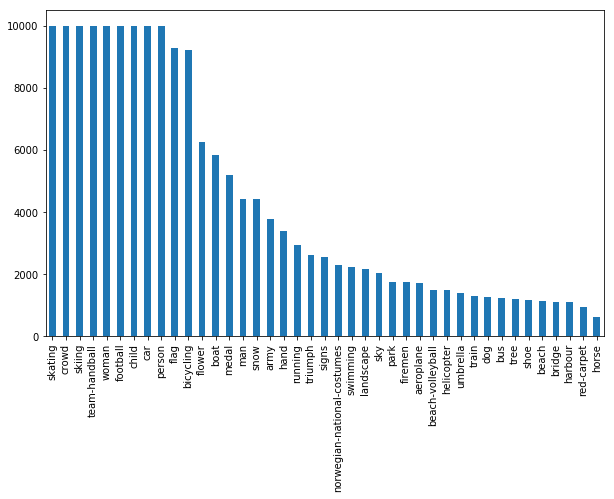

In [70]:
plot_distribution(metadata_balanced)

### Train/Validation/Test dataset split on per category basis

In [9]:
def train_val_test_split(metadata, split=(0.6, 0.2, 0.2)):
    assert sum(split) == 1
    train_ratio, val_ratio, test_ratio = split
    train, val, test = {}, {}, {}
    for label, imgs in metadata.iteritems():
        np.random.shuffle(imgs)
        train[label] = imgs[:int(imgs.size * train_ratio)]
        val[label] = imgs[int(imgs.size * train_ratio):int(imgs.size * (train_ratio + val_ratio))]
        test[label] = imgs[int(imgs.size * (train_ratio + val_ratio)):]
    return train, val, test

In [12]:
train, val, test = train_val_test_split(metadata_balanced)

### Write sampled metadata to sub directory

In [18]:
def dump_training_data(data, split):
    sub_path = os.path.join(BASE_DIR, 'training_data', SUB_DIR)
    training_data = {}
    for label, imgs in data.iteritems():
        for index in imgs:
            training_data.setdefault(index, {})
            if 'folder' not in training_data[index]:
                training_data[index]['folder'] = db.metadata[index]['folder']
            training_data[index].setdefault('labels', []).append(labels.tolist().index(label))
    data_path = os.path.join(BASE_DIR, 'training_data', SUB_DIR, split + '.pickle')
    with open(data_path, mode='w') as f:
        pickle.dump(training_data, f, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
dump_training_data(train, 'train')
dump_training_data(val, 'val')

# Training

In [4]:
caffe.set_mode_gpu()

### Define network

In [5]:
def conv_relu(bottom, ks, nout, stride=1, pad=0, group=1):
    conv = L.Convolution(bottom, kernel_size=ks, stride=stride,
                                num_output=nout, pad=pad, group=group)
    return conv, L.ReLU(conv, in_place=True)

def fc_relu(bottom, nout):
    fc = L.InnerProduct(bottom, num_output=nout)
    return fc, L.ReLU(fc, in_place=True)

def max_pool(bottom, ks, stride=1):
    return L.Pooling(bottom, pool=P.Pooling.MAX, kernel_size=ks, stride=stride)

def caffenet_multilabel(data_layer_params):
    # setup the ntb data layer 
    n = caffe.NetSpec()
    n.data, n.label = L.Python(
        module='ntb.layer.data', layer='NTBDataLayer', 
        ntop=2, param_str=str(data_layer_params)
    )

    # caffenet
    n.conv1, n.relu1 = conv_relu(n.data, 11, 96, stride=4)
    n.pool1 = max_pool(n.relu1, 3, stride=2)
    n.norm1 = L.LRN(n.pool1, local_size=5, alpha=1e-4, beta=0.75)
    n.conv2, n.relu2 = conv_relu(n.norm1, 5, 256, pad=2, group=2)
    n.pool2 = max_pool(n.relu2, 3, stride=2)
    n.norm2 = L.LRN(n.pool2, local_size=5, alpha=1e-4, beta=0.75)
    n.conv3, n.relu3 = conv_relu(n.norm2, 3, 384, pad=1)
    n.conv4, n.relu4 = conv_relu(n.relu3, 3, 384, pad=1, group=2)
    n.conv5, n.relu5 = conv_relu(n.relu4, 3, 256, pad=1, group=2)
    n.pool5 = max_pool(n.relu5, 3, stride=2)
    n.fc6, n.relu6 = fc_relu(n.pool5, 4096)
    n.drop6 = L.Dropout(n.relu6, in_place=True)
    n.fc7, n.relu7 = fc_relu(n.drop6, 4096)
    n.drop7 = L.Dropout(n.relu7, in_place=True)
    n.score = L.InnerProduct(n.drop7, num_output=labels.size)
    
    # Changed loss function
    n.loss = L.SigmoidCrossEntropyLoss(n.score, n.label)
    
    return str(n.to_proto())

### Write nets and solver files

In [12]:
workdir = os.path.join('/models/ntb/', SUB_DIR)
if not os.path.isdir(workdir):
    os.makedirs(workdir)

solverprototxt = tools.CaffeSolver(
    trainnet_prototxt_path=os.path.join(workdir, "trainnet.prototxt"),
    testnet_prototxt_path=os.path.join(workdir, "valnet.prototxt"),
)
solverprototxt.sp['base_lr'] = "0.0001"
solverprototxt.sp['display'] = "1"
solverprototxt.sp['snapshot'] = "200"
solverprototxt.sp['lr_policy'] = '"inv"'
solverprototxt.sp['power'] = "0.5"
solverprototxt.sp['snapshot_prefix'] = '"{}"'.format(os.path.join(workdir, 'snapshots'))
solverprototxt.write(os.path.join(workdir, 'solver.prototxt'))

base_data_layer_params = dict(
    batch_size=124,
    im_shape=[227, 227],
    ntb_root=BASE_DIR,
    sub_dir=SUB_DIR,
    num_labels=labels.size
)
# write train net.
with open(os.path.join(workdir, 'trainnet.prototxt'), 'w') as f:
    data_layer_params = dict(split='train', **base_data_layer_params)
    f.write(caffenet_multilabel(data_layer_params))

# write validation net.
with open(os.path.join(workdir, 'valnet.prototxt'), 'w') as f:
    data_layer_params = dict(split='val', **base_data_layer_params)
    f.write(caffenet_multilabel(data_layer_params))

### Load solver

In [13]:
solver = caffe.SGDSolver(os.path.join(workdir, 'solver.prototxt'))
solver.net.copy_from('/models/caffenet/bvlc_reference_caffenet.caffemodel')
solver.test_nets[0].share_with(solver.net)
solver.step(1)

BatchLoader initialized with 94241 images
NTBDataLayer initialized for sub_dir: ft_noaug, split: train, with bs: 124, im_shape: [227, 227], num_labels: 41.
BatchLoader initialized with 34337 images
NTBDataLayer initialized for sub_dir: ft_noaug, split: val, with bs: 124, im_shape: [227, 227], num_labels: 41.


Check images and labels

In [22]:
# transformer = tools.SimpleTransformer()
# image_index = 2
# pyplot.figure()
# pyplot.imshow(transformer.deprocess(copy(solver.net.blobs['data'].data[image_index, ...])))
# gtlist = solver.net.blobs['label'].data[image_index, ...].astype(np.int)
# pyplot.title('GT: {}'.format(labels[np.where(gtlist)]))
# pyplot.axis('off');

### Train network

In [8]:
# Use hammind distance to check accuracy

def hamming_distance(gt, est):
    return sum([1 for (g, e) in zip(gt, est) if g == e]) / float(len(gt))

def check_accuracy(net, num_batches, batch_size = 128):
    acc = 0.0
    for t in range(num_batches):
        net.forward()
        gts = net.blobs['label'].data
        ests = net.blobs['score'].data > 0
        for gt, est in zip(gts, ests): #for each ground truth and estimated label vector
            acc += hamming_distance(gt, est)
    return acc / (num_batches * batch_size)

In [9]:
def train():
    for itt in range(10):
        solver.step(100)
        print 'itt:{:3d}'.format((itt + 1) * 100), 'accuracy:{0:.4f}'.format(check_accuracy(solver.test_nets[0], 50))

In [ ]:
%time train()

In [ ]:
def check_baseline_accuracy(net, num_batches, batch_size = 128):
    acc = 0.0
    for t in range(num_batches):
        net.forward()
        gts = net.blobs['label'].data
        ests = np.zeros((batch_size, len(gts)))
        for gt, est in zip(gts, ests): #for each ground truth and estimated label vector
            acc += hamming_distance(gt, est)
    return acc / (num_batches * batch_size)

print 'Baseline accuracy:{0:.4f}'.format(check_baseline_accuracy(solver.test_nets[0], 5823/128))

### Look at some prediction results

In [ ]:
test_net = solver.test_nets[0]
for image_index in range(100):
    gtlist = test_net.blobs['label'].data[image_index, ...].astype(np.int)
    estlist = test_net.blobs['score'].data[image_index, ...] > 0
    if labels[np.where(estlist)]:
        plt.figure()
        plt.imshow(transformer.deprocess(copy(test_net.blobs['data'].data[image_index, ...])))
        plt.title('GT: {} \n EST: {}'.format(labels[np.where(gtlist)], labels[np.where(estlist)]))
        plt.axis('off')